<a href="https://colab.research.google.com/github/woranov/amlta-project/blob/main/notebooks/tapas_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import amlta  # noqa: F401
except ImportError:
    %pip install --no-dependencies -U git+https://github.com/woranov/amlta-project.git

  Cloning https://github.com/woranov/amlta-project.git to /tmp/pip-req-build-5m4kl020
  Running command git clone --filter=blob:none --quiet https://github.com/woranov/amlta-project.git /tmp/pip-req-build-5m4kl020
  Resolved https://github.com/woranov/amlta-project.git to commit f50931181d388aaa3406eeb63e977a9fb78ab25e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for amlta: filename=amlta-0.1.0-py3-none-any.whl size=37477 sha256=465d5c9a2ee0eb473ecca33f95764b2c029f3094a0c9f7d3fe3e98bf59297800
  Stored in directory: /tmp/pip-ephem-wheel-cache-b9o7yj_c/wheels/3d/ca/aa/08dfcac1c046f6e9611b7206be857f9d9b52d93473f14ef64e
Successfully built amlta


In [2]:
from pathlib import Path

try:
    from google.colab import drive  # pyright: ignore[reportMissingImports]

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from amlta.config import config

In [3]:
if IN_COLAB:
    mount_point = Path("/content/drive")
    drive_path = mount_point / "MyDrive"

    # edit
    data_dir = drive_path / "uni" / "ws2425" / "amlta" / "project" / "data"

    config.update(data_dir=data_dir)

    if not mount_point.exists():
        drive.mount(str(mount_point))

Mounted at /content/drive


In [4]:
%pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [64]:
import functools
import importlib
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import pytorch_lightning as pl
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.tuner import Tuner
from tqdm.auto import tqdm
from transformers import TapasConfig, TapasForQuestionAnswering, TapasTokenizer

from amlta.data_processing.tapas_flows import transform_flows_for_tapas
from amlta.probas import flows, processes
from amlta.question_generation.process import (
    build_training_batched_dfs_all,
    load_batches,
)

processes = importlib.reload(processes)

In [6]:
tapas_config = TapasConfig.from_pretrained(
    "google/tapas-base-finetuned-wikisql-supervised"
)
tapas_model = TapasForQuestionAnswering.from_pretrained(
    "google/tapas-base", config=tapas_config
)
tapas_tokenizer = TapasTokenizer.from_pretrained(
    "google/tapas-base-finetuned-wikisql-supervised"
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tapas_model.to(device)

config.json:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of TapasForQuestionAnswering were not initialized from the model checkpoint at google/tapas-base and are newly initialized: ['aggregation_classifier.bias', 'aggregation_classifier.weight', 'column_output_bias', 'column_output_weights', 'output_bias', 'output_weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/490 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/262k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

TapasForQuestionAnswering(
  (tapas): TapasModel(
    (embeddings): TapasEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (token_type_embeddings_0): Embedding(3, 768)
      (token_type_embeddings_1): Embedding(256, 768)
      (token_type_embeddings_2): Embedding(256, 768)
      (token_type_embeddings_3): Embedding(2, 768)
      (token_type_embeddings_4): Embedding(256, 768)
      (token_type_embeddings_5): Embedding(256, 768)
      (token_type_embeddings_6): Embedding(10, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): TapasEncoder(
      (layer): ModuleList(
        (0-11): 12 x TapasLayer(
          (attention): TapasAttention(
            (self): TapasSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias

In [7]:
results = load_batches()

In [8]:
# extremely slow thanks to I/O on colab :')
examples_batched_df = build_training_batched_dfs_all()
examples_batched_df

,batch,question_id,question_template,question_basic,question_general,question_specific,process_uuid,flows_start,flows_stop,aggregation,coordinates,answers
0,batch_gpt-4o-mini_200_400,0,What are the emissions associated with the out...,What are the emissions associated with the out...,What are the emissions associated with the out...,What are the emissions associated with the out...,6bb2495e-0106-4cc8-98a4-b528443c152a,0,15,NONE,[],[]
1,batch_gpt-4o-mini_200_400,0,What are the emissions associated with the out...,What are the emissions associated with the out...,What are the emissions associated with the out...,What are the emissions associated with the out...,6bb2495e-0106-4cc8-98a4-b528443c152a,15,30,NONE,"[(12, 1), (13, 1), (14, 1)]","[772.0, 39.0, 0.0]"
2,batch_gpt-4o-mini_200_400,0,What are the emissions associated with the out...,What are the emissions associated with the out...,What are the emissions associated with the out...,What are the emissions associated with the out...,6bb2495e-0106-4cc8-98a4-b528443c152a,30,45,NONE,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00..."
3,batch_gpt-4o-mini_200_400,0,What are the emissions associated with the out...,What are the emissions associated with the out...,What are the emissions associated with the out...,What are the emissions associated with the out...,6bb2495e-0106-4cc8-98a4-b528443c152a,45,60,NONE,"[(0, 1), (1, 1), (2, 1), (3, 1), (5, 1), (6, 1...","[0.001, 61.6, 56.9, 0.006, 0.0, 0.0, 0.0, 0.0,..."
4,batch_gpt-4o-mini_200_400,0,What are the emissions associated with the out...,What are the emissions associated with the out...,What are the emissions associated with the out...,What are the emissions associated with the out...,6bb2495e-0106-4cc8-98a4-b528443c152a,60,75,NONE,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[0.0, 0.0, 0.0, 0.0, 0.01, 0.02, 0.694, 0.0, 3..."
...,...,...,...,...,...,...,...,...,...,...,...,...
20719,batch_gpt-4o-mini_800_1000,2,"What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...",ecf185cb-c44b-4450-abc4-a92c4bf0b9b9,0,15,COUNT,[],[]
20720,batch_gpt-4o-mini_800_1000,2,"What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...",ecf185cb-c44b-4450-abc4-a92c4bf0b9b9,15,30,COUNT,"[(10, 1), (11, 1)]","[0.0, 0.0]"
20721,batch_gpt-4o-mini_800_1000,2,"What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...",ecf185cb-c44b-4450-abc4-a92c4bf0b9b9,30,45,COUNT,"[(9, 1)]",[0.0]
20722,batch_gpt-4o-mini_800_1000,2,"What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...","What are the output amounts of HFC-245ca, perf...",ecf185cb-c44b-4450-abc4-a92c4bf0b9b9,45,60,COUNT,"[(2, 1)]",[0.0]


In [10]:
aggregation2id = {agg: id for id, agg in tapas_config.aggregation_labels.items()}

In [11]:
@functools.lru_cache(maxsize=512)
def get_flows_df(uuid: str) -> pd.DataFrame:
    process = processes.ProcessData.from_uuid(uuid)
    return flows.extract_process_flows(process)


class TableDataset(torch.utils.data.Dataset):
    def __init__(
        self, df: pd.DataFrame, tokenizer: TapasTokenizer, table_chunk_size: int = 20
    ):
        super().__init__()
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            indices = range(*idx.indices(len(self)))
            return [self[i] for i in indices]

        item = self.df.iloc[idx]

        # question_specific = item["question_specific"]
        question_general = item["question_general"]
        question_process_agnostic = (
            item["question_template"].replace("<", "").replace(">", "")
        )

        flows_df = (
            get_flows_df(item["process_uuid"])
            .iloc[item["flows_start"] : item["flows_stop"]]
            .reset_index(drop=True)
        )
        table = transform_flows_for_tapas(flows_df).astype(str)

        # display(flows_df)
        # display(table)

        encoding = self.tokenizer(
            table=table,
            queries=question_process_agnostic,
            answer_coordinates=item["coordinates"],
            answer_text=item["answers"],
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        # remove the batch dimension which the tokenizer adds by default
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        encoding["aggregation_labels"] = aggregation2id[item["aggregation"]]

        return encoding

In [24]:
# Define a LightningModule for your TAPAS model.
class TapasLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate=5e-5):
        """
        Args:
            model: A pretrained TAPAS model.
            learning_rate: The learning rate for the optimizer.
        """
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, batch):
        # Forward pass that expects a batch dictionary with all required keys.
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch["token_type_ids"],
            labels=batch["labels"],
            numeric_values=batch["numeric_values"],
            numeric_values_scale=batch["numeric_values_scale"],
            aggregation_labels=batch["aggregation_labels"],
        )

    def training_step(self, batch, batch_idx):
        outputs = self.forward(batch)
        loss = outputs.loss
        # Log training loss on both step and epoch levels.
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.forward(batch)
        loss = outputs.loss
        # Log validation loss only at the epoch level.
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):  # Add this method
        outputs = self.forward(batch)
        loss = outputs.loss
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)
        return optimizer


In [69]:
# Assume that `examples_batched_df`, `tapas_tokenizer`, and `tapas_model` are defined elsewhere.
# Split the dataset into training and validation parts.
split_idx = int(len(examples_batched_df) * 0.8)
train_dataset = TableDataset(
    df=examples_batched_df.iloc[:split_idx],
    tokenizer=tapas_tokenizer
)
val_dataset = TableDataset(
    df=examples_batched_df.iloc[split_idx:],
    tokenizer=tapas_tokenizer
)

# Create DataLoaders.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the LightningModule with your TAPAS model.
tapas_lightning = TapasLightningModule(tapas_model, learning_rate=5e-5)

# Set up checkpointing: this callback will monitor 'val_loss' and save the best model.
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename="tapas-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min",
)

# Create a PyTorch Lightning Trainer.
trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback],
    log_every_n_steps=10,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 3.5481338923357546e-06
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_f37f2d79-0ffa-4242-8c47-4d0243c07e59.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_f37f2d79-0ffa-4242-8c47-4d0243c07e59.ckpt


Suggested learning rate: 3.5481338923357546e-06


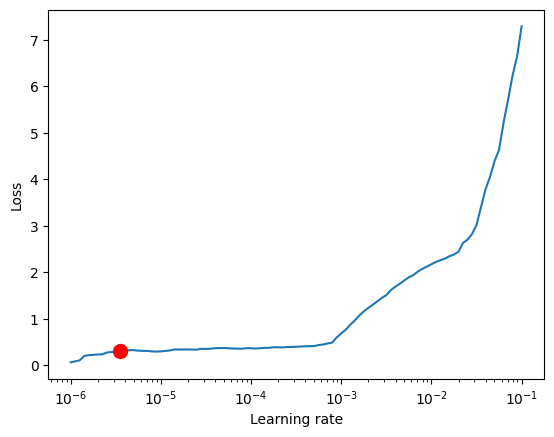

In [71]:
tuner = Tuner(trainer)

lr_finder = tuner.lr_find(
    tapas_lightning, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
    min_lr=1e-6, max_lr=1e-1, early_stop_threshold=None,
)

# Retrieve the suggested learning rate.
new_lr = lr_finder.suggestion()
print(f"Suggested learning rate: {new_lr}")

if new_lr:
    # Update the LightningModule with the new learning rate.
    tapas_lightning.learning_rate = new_lr

# Optionally, display the learning rate vs loss plot.
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
# Start training.
trainer.fit(tapas_lightning, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params | Mode
-----------------------------------------------------------
0 | model | TapasForQuestionAnswering | 110 M  | eval
-----------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.706   Total estimated model params size (MB)
0         Modules in train mode
237       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/call.py", line 47, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 575, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 982, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py", line 1026, in _run_stage
    self.fit_loop.run()
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py", line 216, in run
    self.advance()
  File "/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py", line 455, in advance
    self.epoch_loop.run(self._data_fetcher)
  File "/usr/local/lib/python3.11/

In [25]:
fitted_model = TapasLightningModule.load_from_checkpoint(
    "/content/checkpoints/tapas-epoch=00-val_loss=0.38.ckpt",
    model=tapas_model,
)

fitted_model.eval()

trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1
)
trainer.valid(fitted_model, dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.43634212017059326    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.43634212017059326}]

In [63]:
fitted_model.to(device)
fitted_model.eval()

ex = examples_batched_df.iloc[int(len(examples_batched_df) * 0.8) :].sample(1).iloc[0]
question_general = ex["question_general"]
question_process_agnostic = ex["question_template"].replace("<", "").replace(">", "")

flows_df = (
    get_flows_df(ex["process_uuid"])
    .iloc[ex["flows_start"] : ex["flows_stop"]]
    .reset_index(drop=True)
)
table = transform_flows_for_tapas(flows_df).astype(str)

queries = question_process_agnostic

display(table)
print(queries)

inputs = tapas_tokenizer(
    table=table, queries=queries, padding="max_length", return_tensors="pt"
)
with torch.no_grad():
    outputs = fitted_model.model(**inputs.to(device))
    predicted_answer_coordinates, predicted_aggregation_indices = (
        tapas_tokenizer.convert_logits_to_predictions(
            inputs.to("cpu"),
            outputs.logits.detach().to("cpu"),
            outputs.logits_aggregation.detach().to("cpu"),
            cell_classification_threshold=0.15,
        )
    )

# let's print out the results:
id2aggregation = {0: "NONE", 1: "SUM", 2: "AVERAGE", 3: "COUNT"}
aggregation_predictions_string = [
    id2aggregation[x] for x in predicted_aggregation_indices
]

print(aggregation_predictions_string)
print(predicted_answer_coordinates)

print(ex["coordinates"])

,Direction,Amount,Type,Class,Name,Property,Unit
0,Input,103.0,Waste flow,End-of-life treatment / Energy recycling,secondary raw materials,Net calorific value,MJ
1,Input,0.658,Waste flow,End-of-life treatment / Material recycling,secondary raw materials,Mass,kg
2,Input,0.274,Waste flow,End-of-life treatment / Other end-of-life serv...,NF-scrap,Mass,kg
3,Input,889.0,Waste flow,End-of-life treatment / Other end-of-life serv...,waste,Net calorific value,MJ
4,Input,0.0,Waste flow,End-of-life treatment / Material recycling,Fe-scrap,Mass,kg
5,Input,22.4,Waste flow,End-of-life treatment / Material recycling,iron-scrap,Mass,kg
6,Input,3980.0,Elementary flow,Resources / Resources from air / Renewable ene...,primary energy from wind power,Net calorific value,MJ
7,Input,1020.0,Elementary flow,Resources / Resources from water / Renewable e...,primary energy from hydro power,Net calorific value,MJ
8,Input,48.11,Elementary flow,Resources / Resources from water / Renewable m...,water,Volume,m3
9,Input,12000.0,Elementary flow,Resources / Resources from ground / Non-renewa...,hard coal,Net calorific value,MJ


How many different input flows classified as resources from air are associated with the process?
['COUNT']
[[(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]
[(6, 1), (10, 1), (12, 1)]


In [ ]:
ex

,3305
batch,batch_gpt-4o-mini_0_200
question_id,2
question_template,What are the amounts of primary energy from re...
question_basic,What are the amounts of primary energy from re...
question_general,What are the amounts of primary energy from re...
question_specific,What are the amounts of primary energy from re...
process_uuid,aab4825f-87a9-4a58-8701-649e83c7a4c8
flows_start,75
flows_stop,79
aggregation,NONE


In [ ]:
params = next(
    res
    for res in results
    if res["process_uuid"] == ex["process_uuid"]
    and res["question_id"] == ex["question_id"]
)

In [ ]:
params

{'batch': 'batch_gpt-4o-mini_0_200',
 'process_uuid': 'aab4825f-87a9-4a58-8701-649e83c7a4c8',
 'question_id': 2,
 'basic_query': 'chemical production processes in Germany',
 'general_query': 'oxygen production process',
 'specific_query': 'liquid oxygen production in Germany 2000',
 'flow_query_params': {'query_type': 'type',
  'direction': 'both',
  'aggregation': 'list',
  'flow_type': 'Elementary flow'},
 'question': 'What are the amounts of primary energy from renewable sources used in <the process>?',
 'question_replaced_basic': 'What are the amounts of primary energy from renewable sources used in chemical production processes in Germany?',
 'question_replaced_general': 'What are the amounts of primary energy from renewable sources used in oxygen production process?',
 'question_replaced_specific': 'What are the amounts of primary energy from renewable sources used in liquid oxygen production in Germany 2000?'}